<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/Monte_Carlo_Candlestick_Chart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade mplfinance
!pip install --upgrade pandas_ta

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas_ta as ta
import datetime as dt

In [3]:
mu = 0.0
sigma = 0.05
S0 = 100
days = 500

In [4]:
def plot_candle_sticks(mu, sigma, S0, days):
    e = np.random.normal(size = [24 * 60, days])

    delta_t = 1.0/(365.0 * 24 * 60)
    prev_S = S0

    list_data = []
    for jdx in range(days):
        candle_data = []

        for idx in range(24 * 60):
            next_S = prev_S * np.exp((mu - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * e[idx, jdx])
            candle_data += [next_S]
            prev_S = next_S

        list_data += [candle_data]

    S = np.array(list_data).T

    date_index = pd.DatetimeIndex([dt.date(2025, 1, 1) + dt.timedelta(delta) for delta in range(days)])

    candlestick_df = pd.DataFrame({
        'Open' : S[0, ...],
        'High' : np.max(S, axis = 0, keepdims = False),
        'Low' : np.min(S, axis = 0, keepdims = False),
        'Close' : S[-1, ...],
    }, index = date_index)

    # Step 2: Calculate technical indicators using pandas-ta
    candlestick_df['5 EMA'] = ta.ema(candlestick_df['Close'], length=5)
    candlestick_df['20 EMA'] = ta.ema(candlestick_df['Close'], length=20)  # 20-day Exponential Moving Average
    candlestick_df['50 EMA'] = ta.ema(candlestick_df['Close'], length=50)  # 50-day Exponential Moving Average
    candlestick_df['200 EMA'] = ta.ema(candlestick_df['Close'], length=200)  # 50-day Exponential Moving Average
    candlestick_df.dropna(inplace = True)

    data_df = candlestick_df

    ema5 = mpf.make_addplot(data_df['5 EMA'], color='black', width=2)
    ema20 = mpf.make_addplot(data_df['20 EMA'], color='green', width=2)
    ema50 = mpf.make_addplot(data_df['50 EMA'], color='blue', width=2)
    ema200 = mpf.make_addplot(data_df['200 EMA'], color='red', width=2)

    mpf.plot(
        data_df,
        type="candle",  # Candlestick chart
        style="yahoo",  # Chart style
        addplot=[ema5, ema20, ema50, ema200],
        figscale = 4
    )

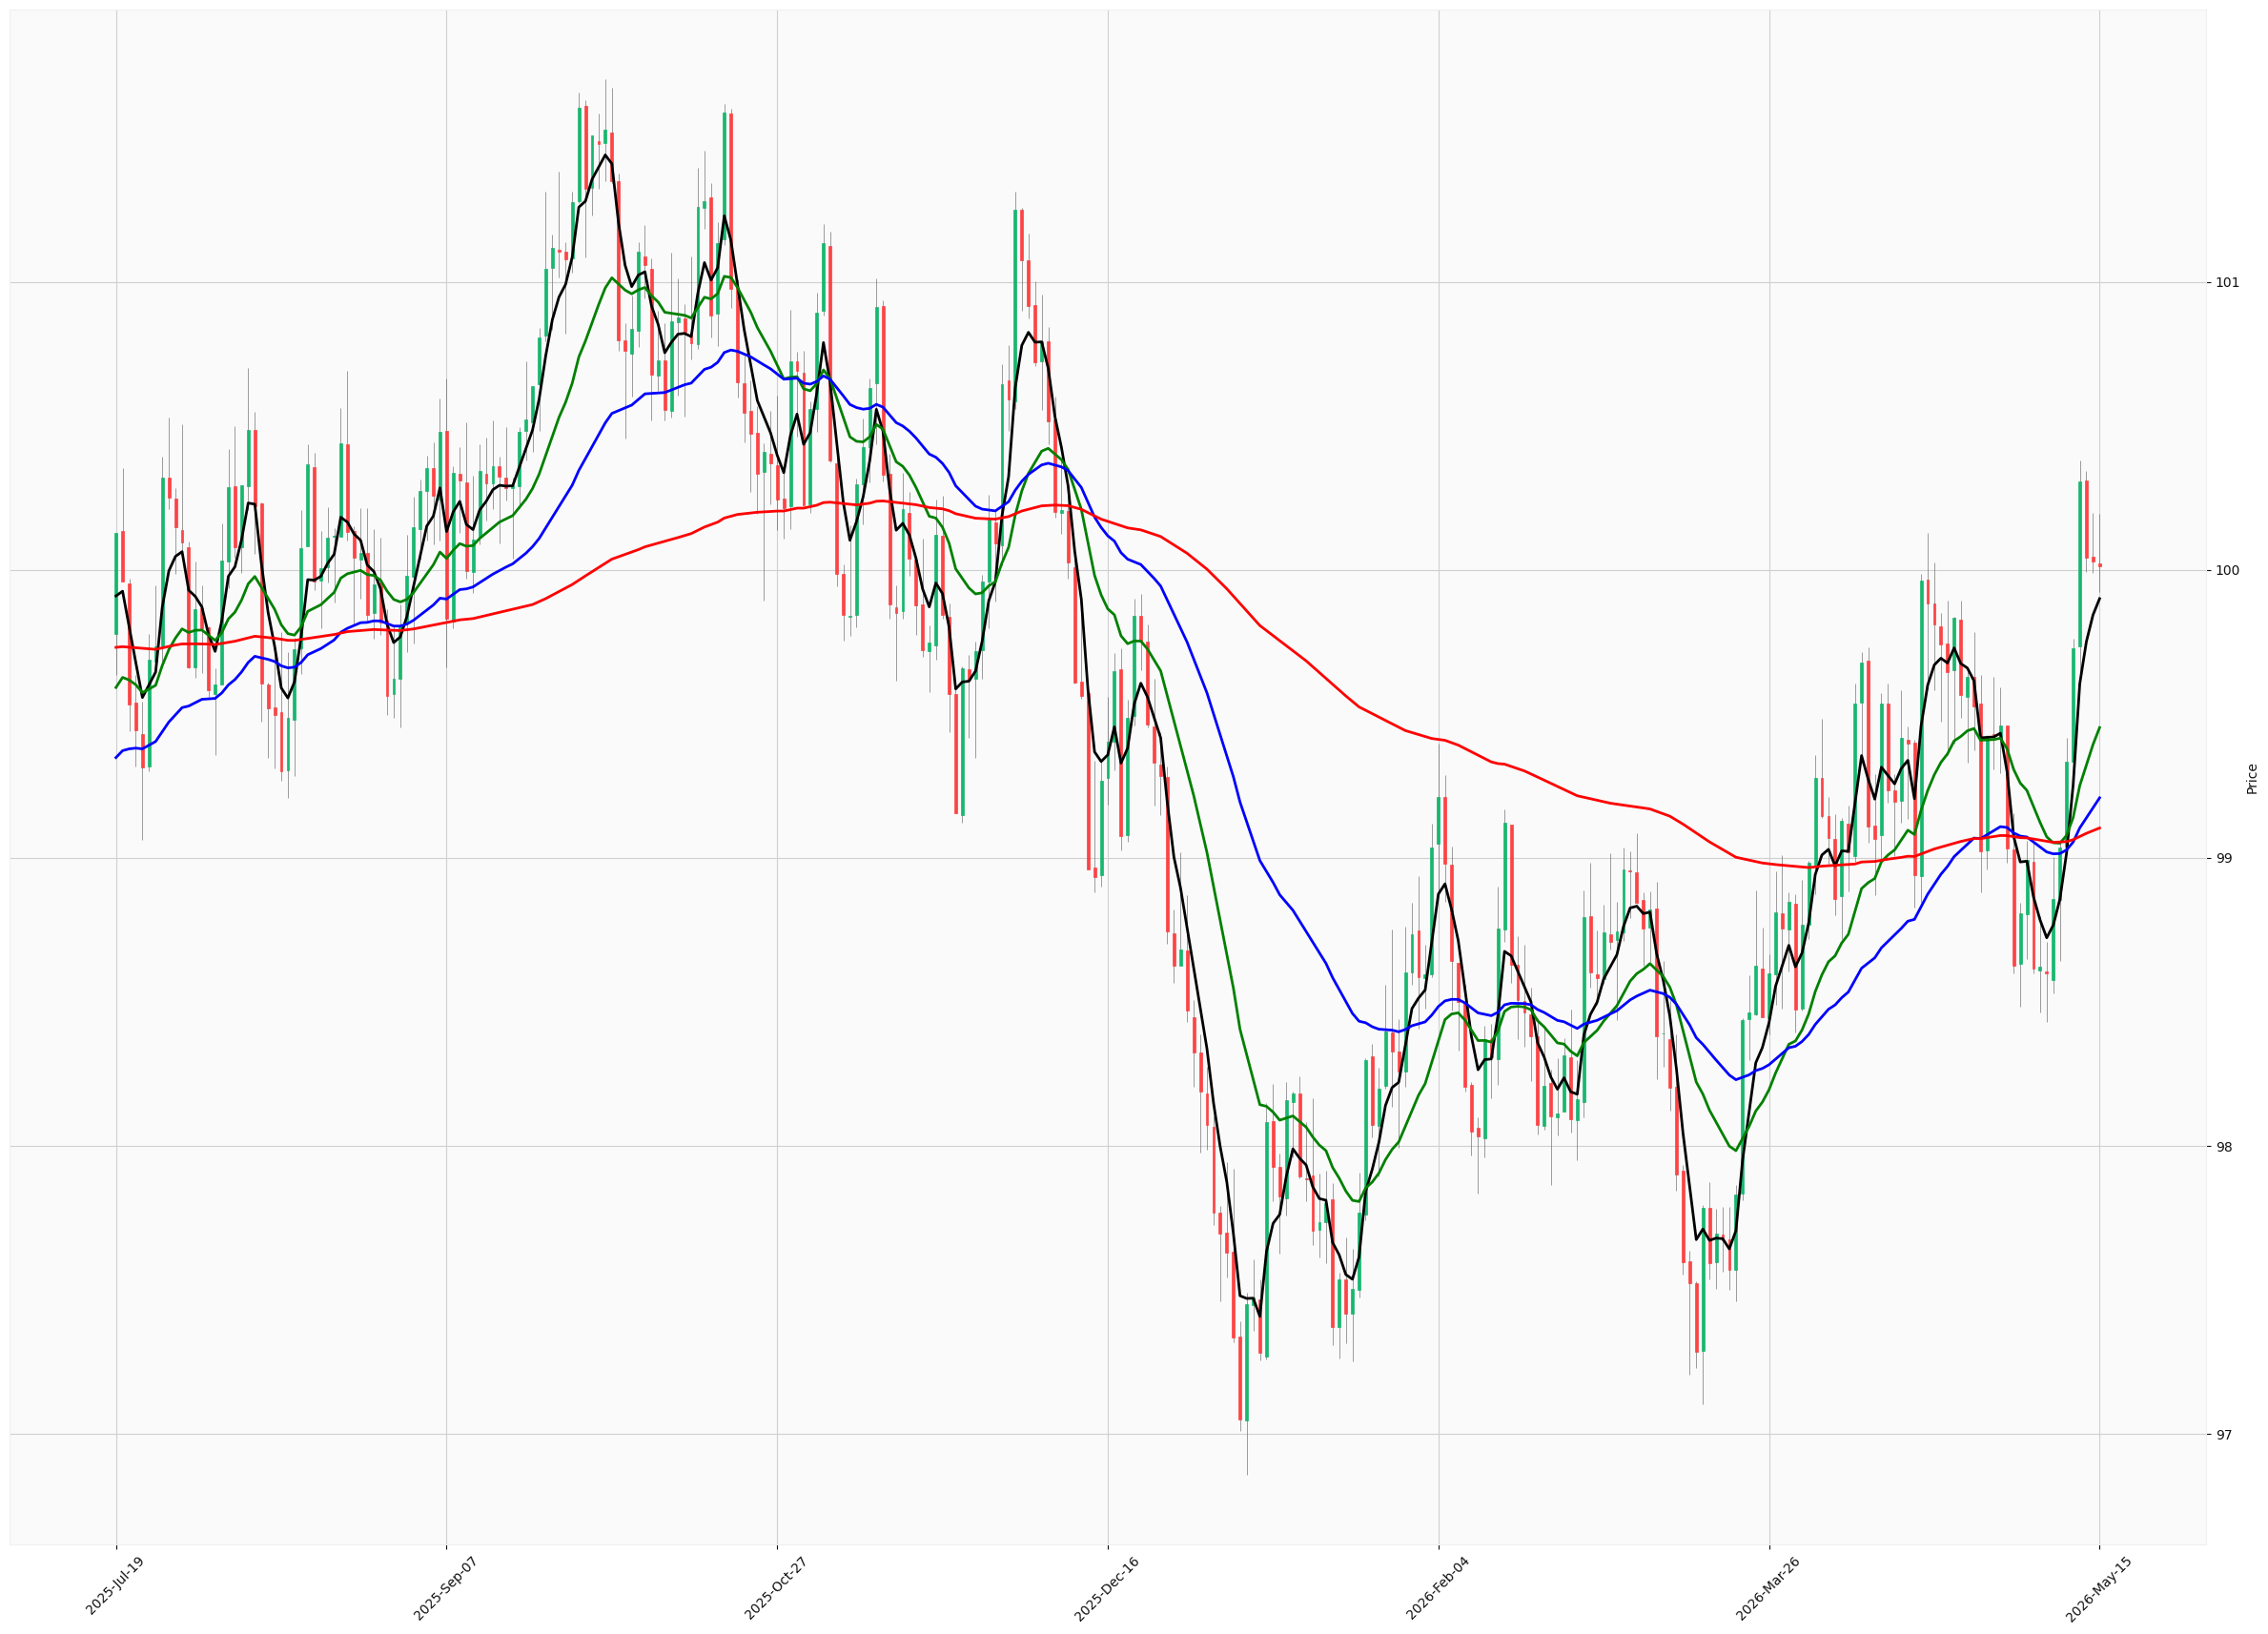

In [5]:
plot_candle_sticks(mu, sigma, S0, days)

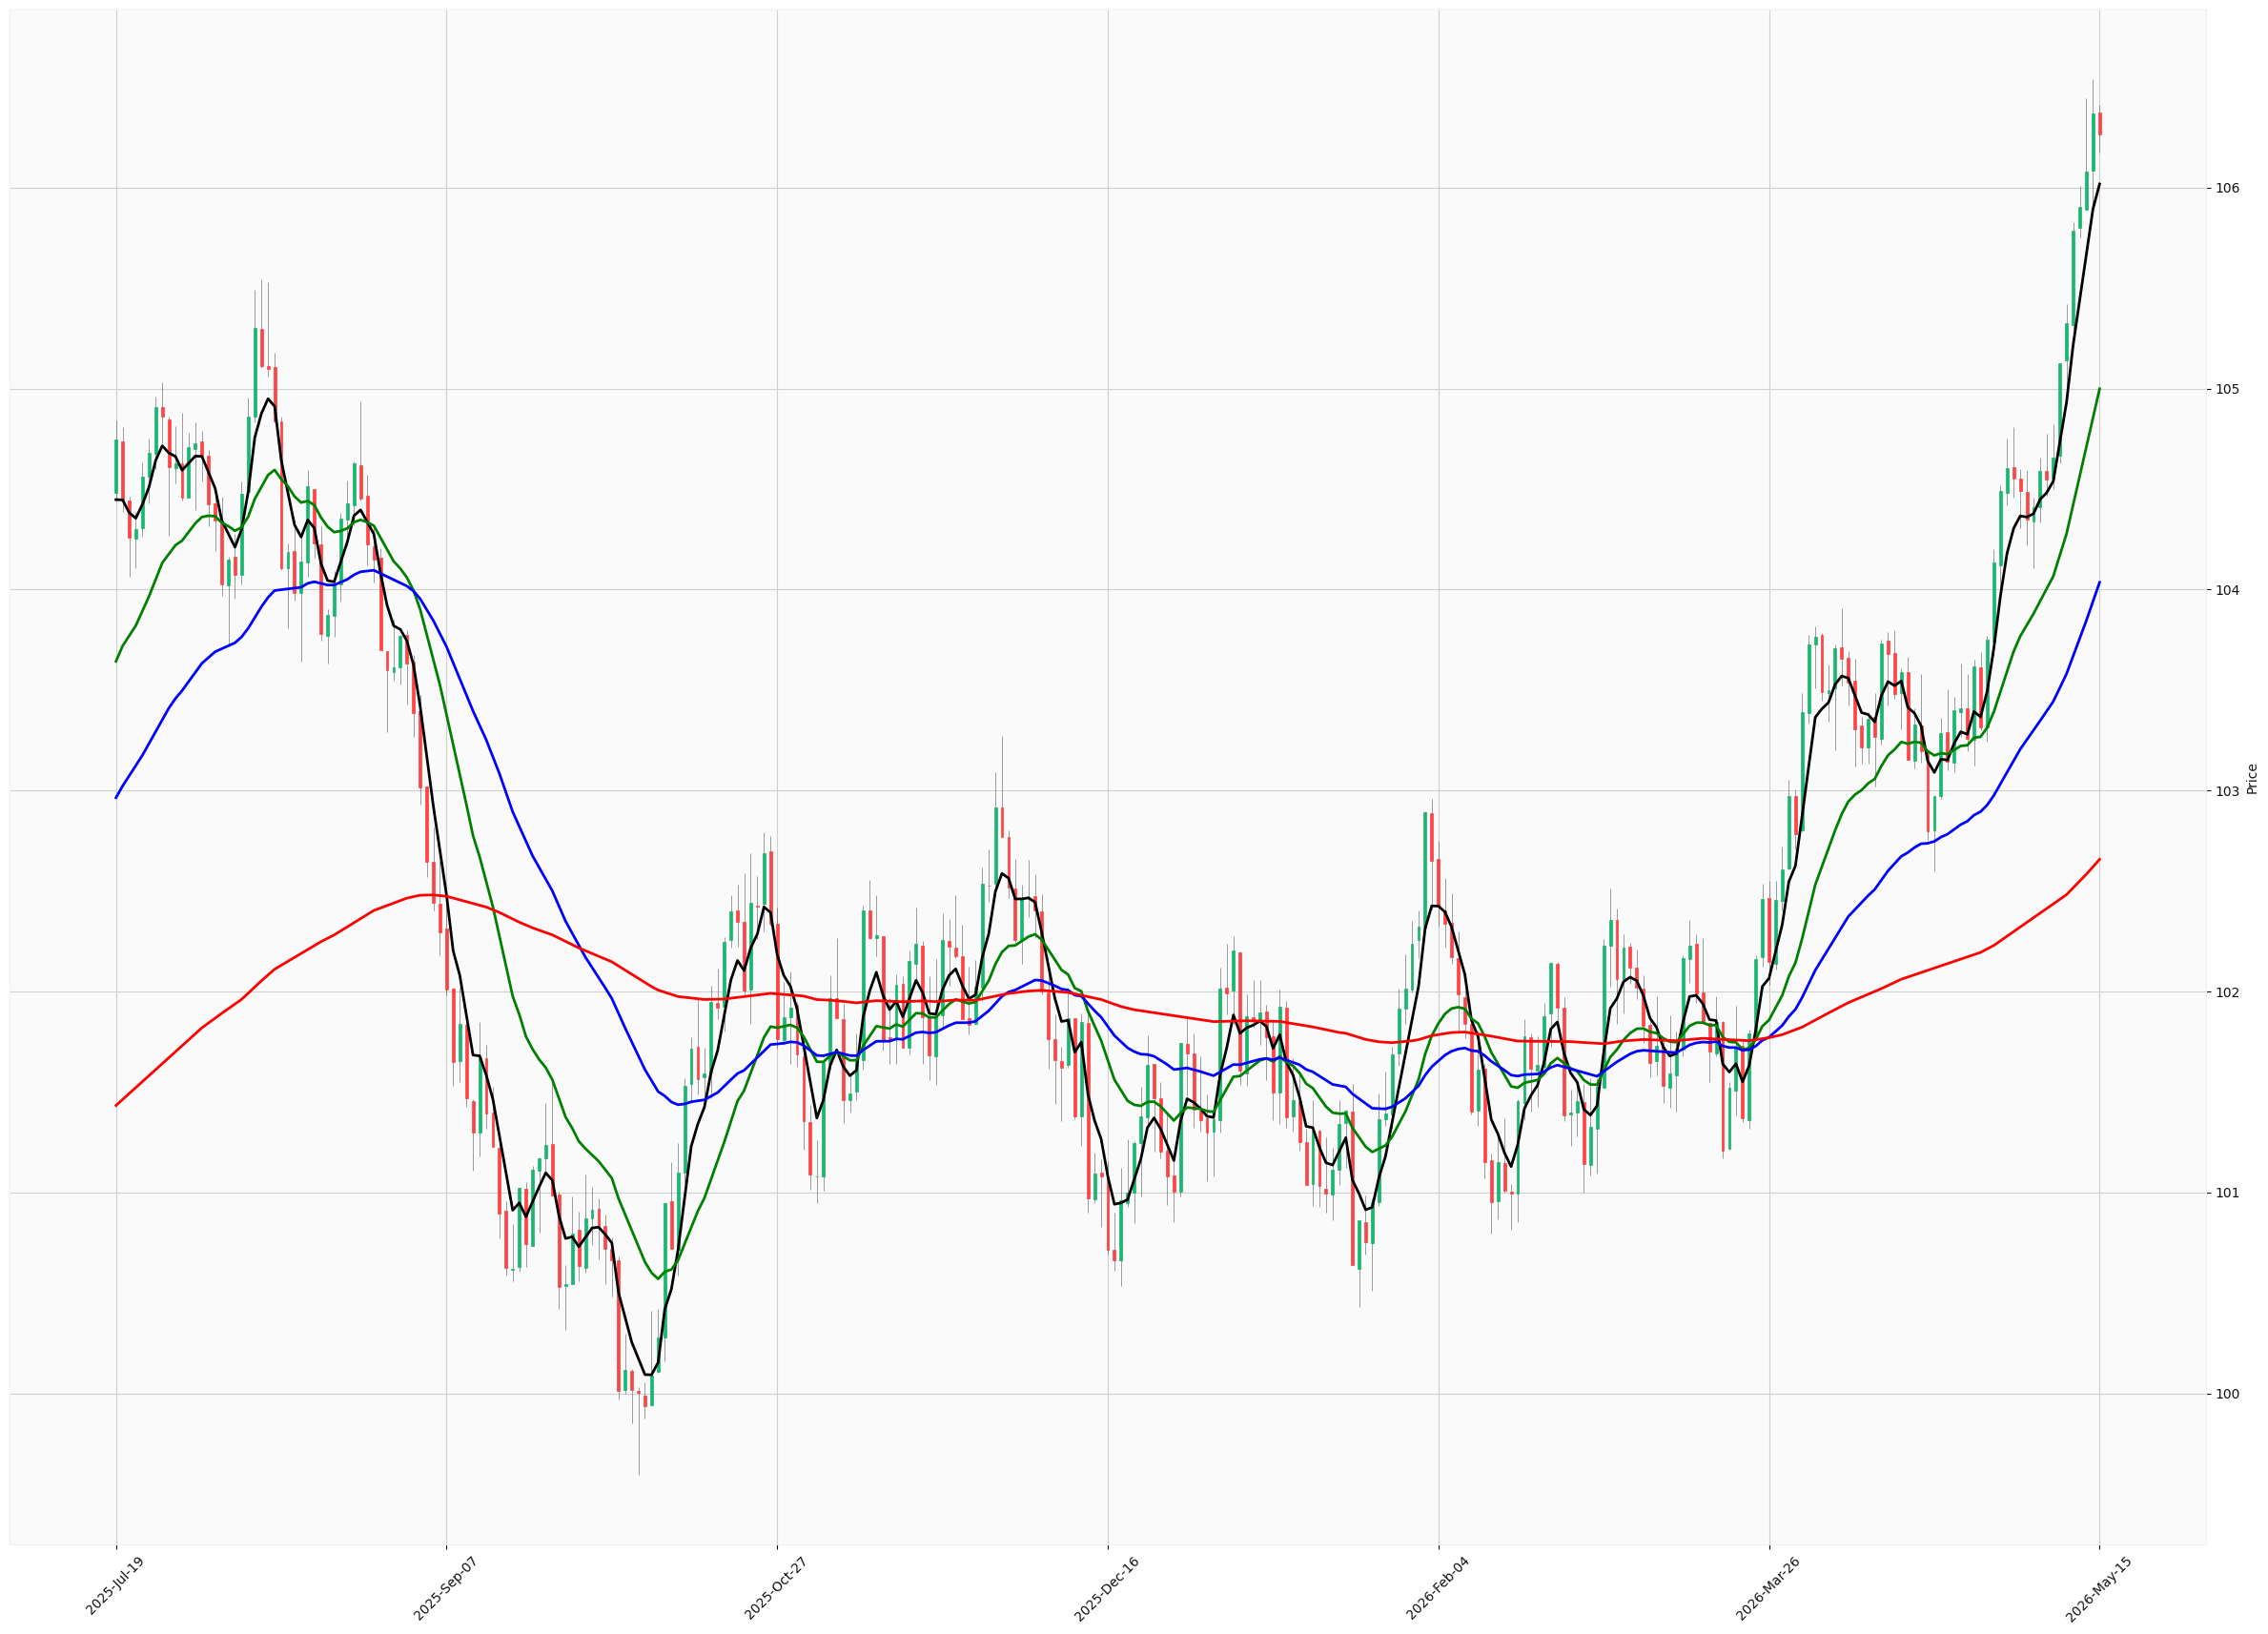

In [6]:
plot_candle_sticks(mu, sigma, S0, days)

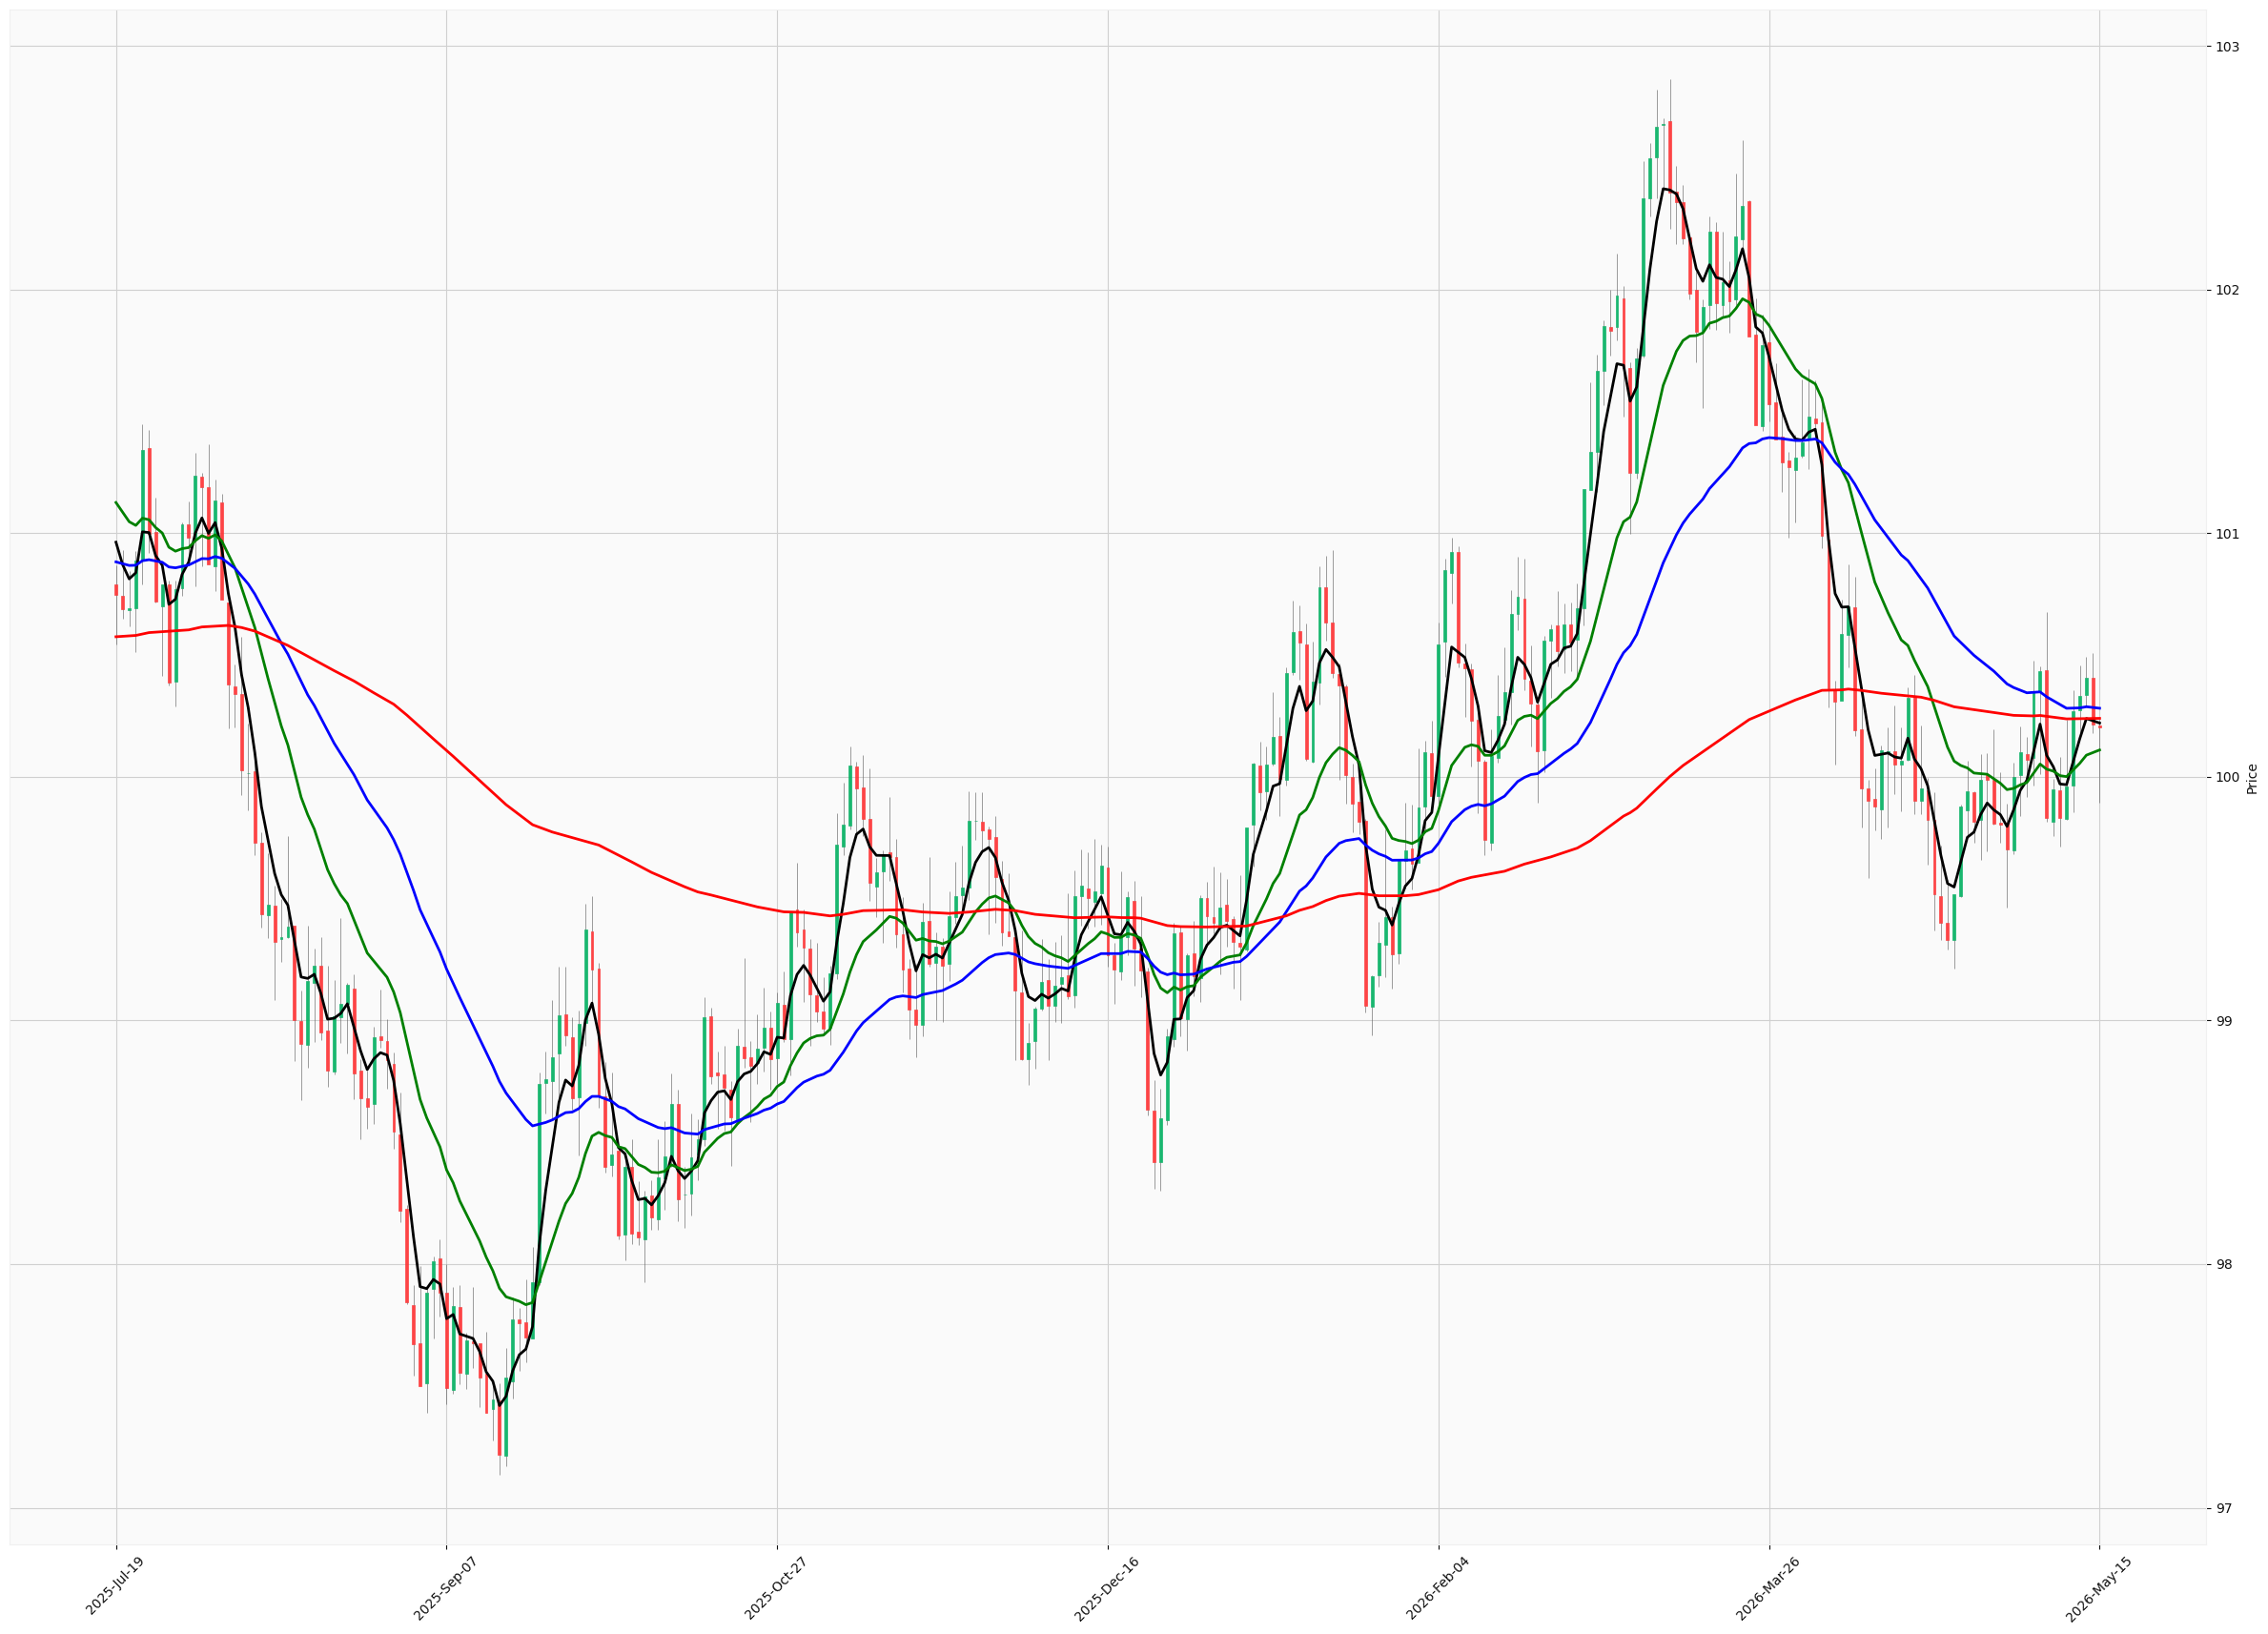

In [7]:
plot_candle_sticks(mu, sigma, S0, days)

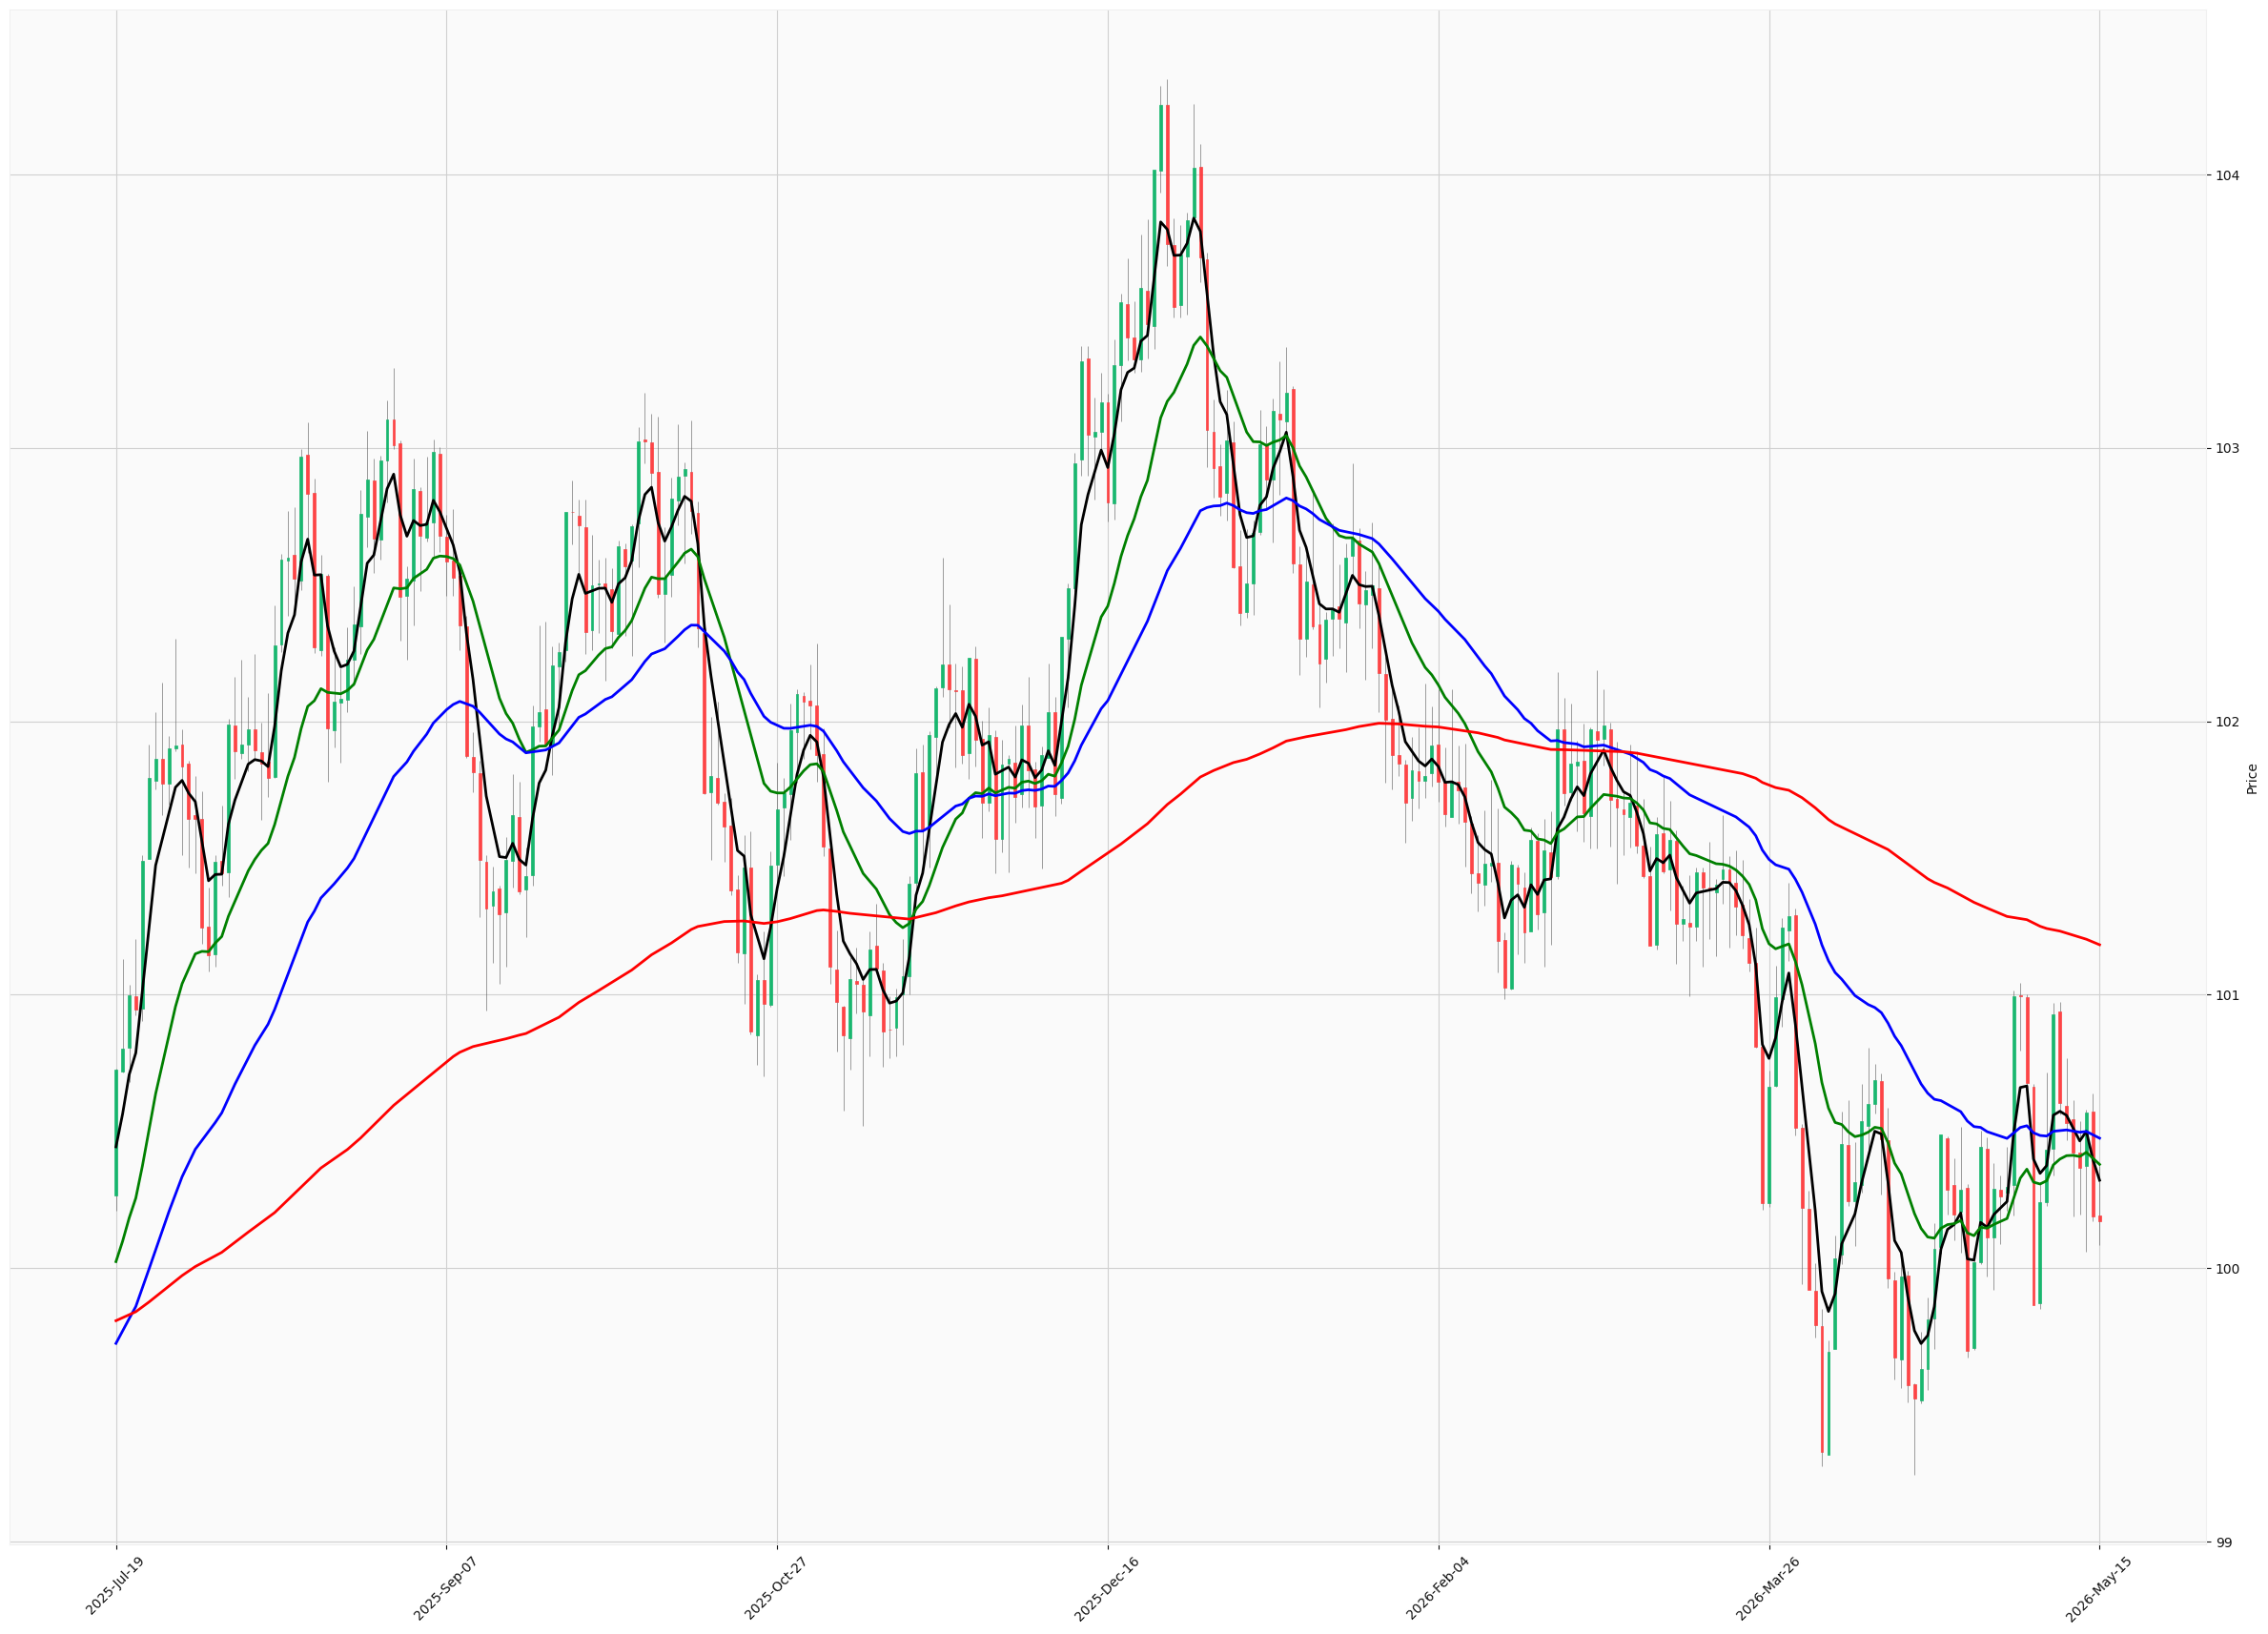

In [8]:
plot_candle_sticks(mu, sigma, S0, days)

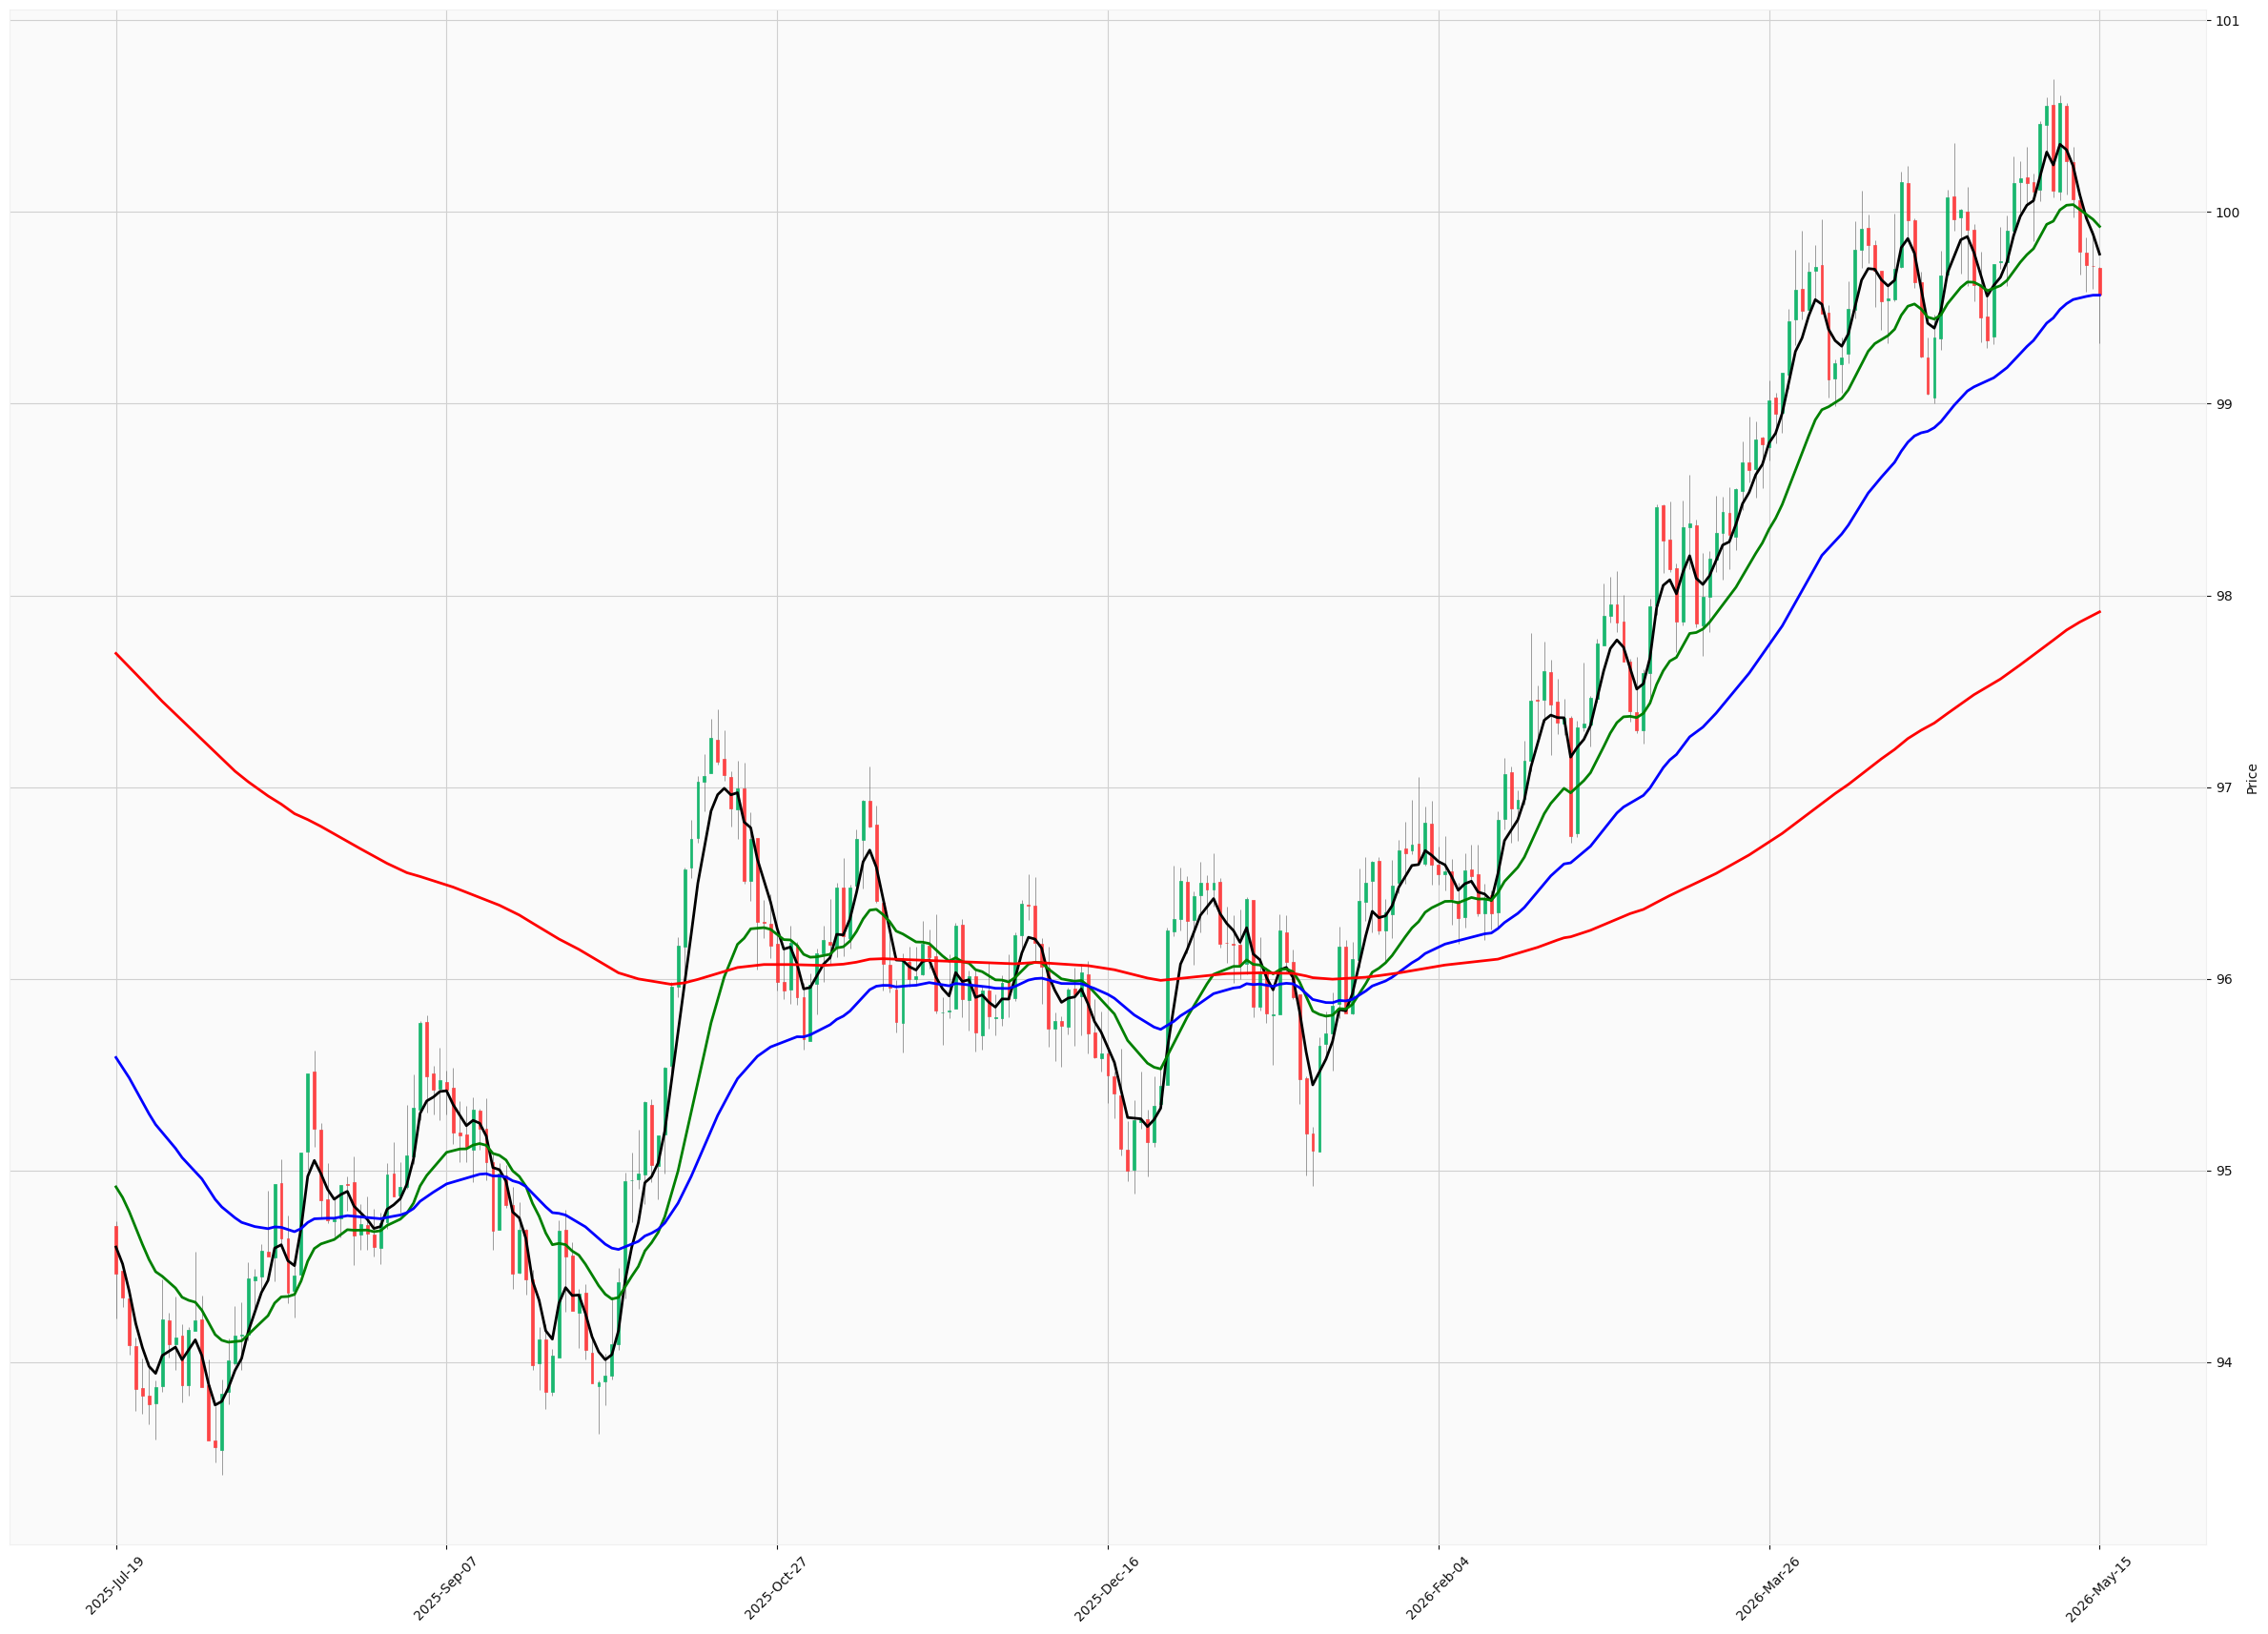

In [9]:
plot_candle_sticks(mu, sigma, S0, days)

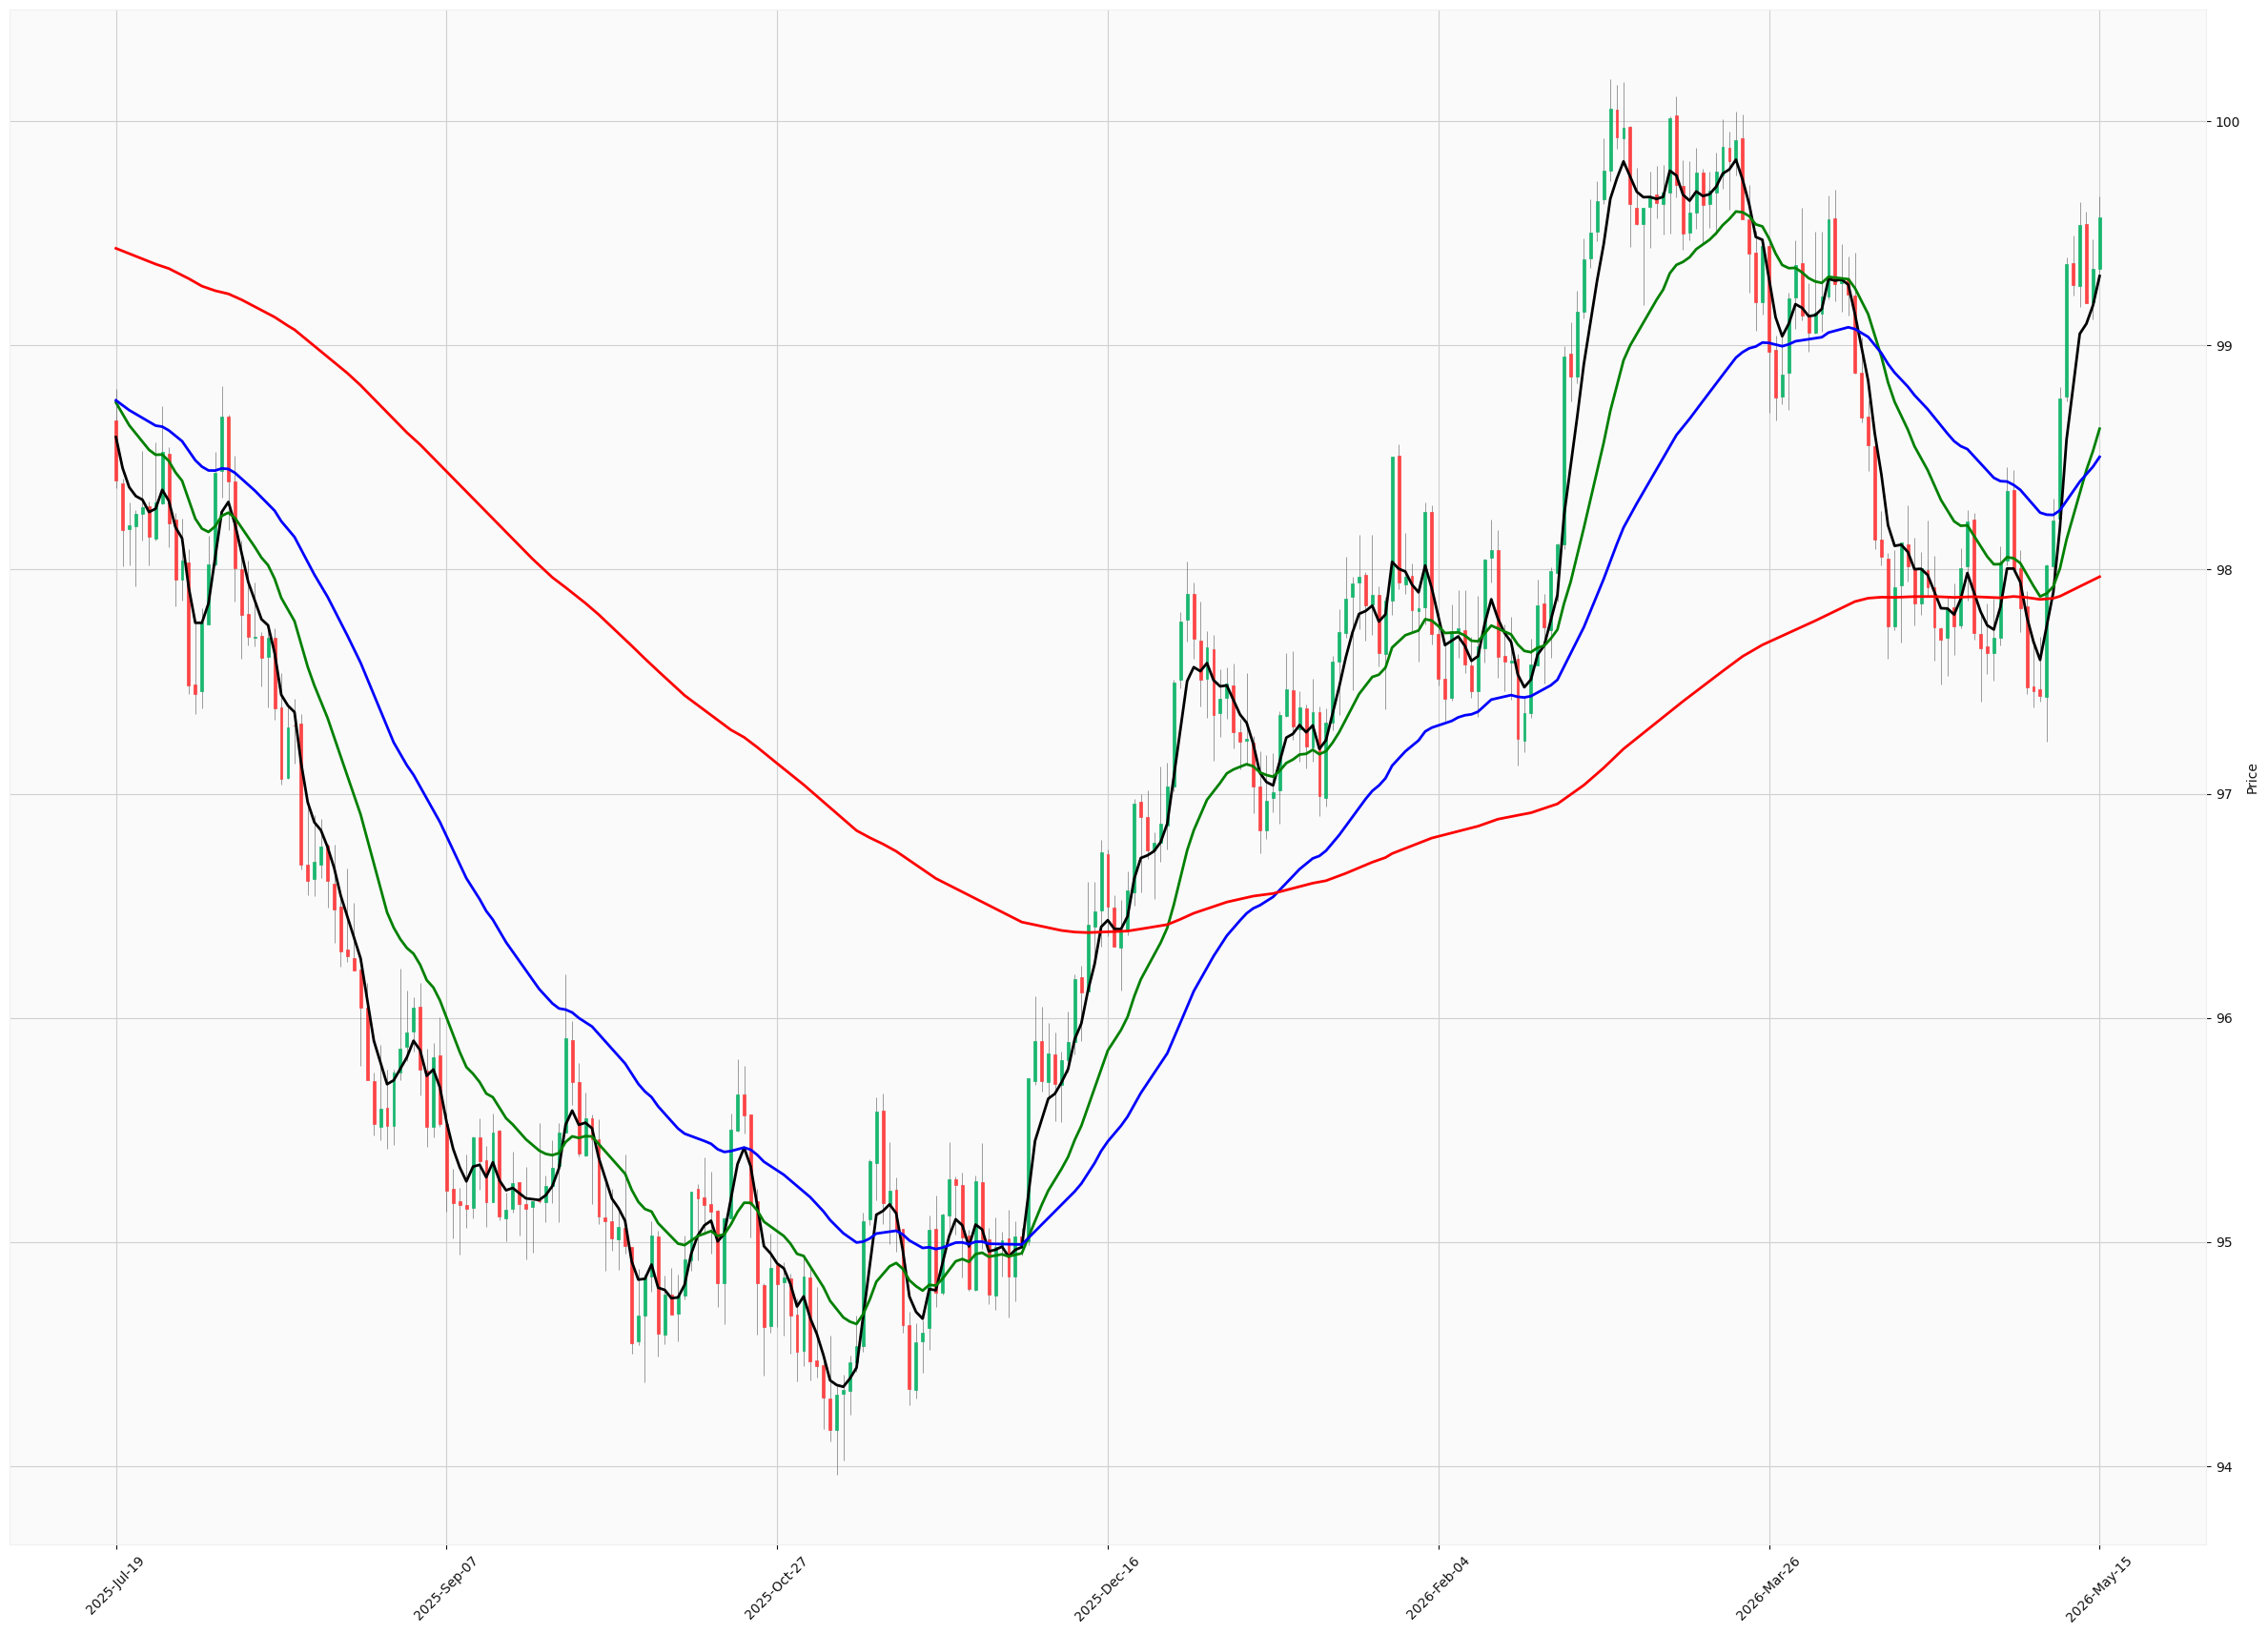

In [10]:
plot_candle_sticks(mu, sigma, S0, days)